# Import and setup

In [30]:
import numpy as np
import matplotlib.pyplot as plt

import few

from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import SchwarzEccFlux, KerrEccEqFlux
# from few.amplitude.romannet import RomanAmplitude
from few.amplitude.ampinterp2d import AmpInterpKerrEccEq
from few.summation.interpolatedmodesum import InterpolatedModeSum, CubicSplineInterpolant


from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few import get_file_manager

from few.waveform import (
    FastKerrEccentricEquatorialFlux,
    FastSchwarzschildEccentricFlux, 
    SlowSchwarzschildEccentricFlux, 
    Pn5AAKWaveform,
    GenerateEMRIWaveform
)

from few.utils.geodesic import get_fundamental_frequencies

# if running in VScode via SSH, ensure the current directory is in the Python path
import os
import sys

# Change to the desired directory
os.chdir('/nfs/home/svu/e1498138/localgit/FEWNEW/work/')

# Add it to Python path
sys.path.insert(0, '/nfs/home/svu/e1498138/localgit/FEWNEW/work/')

import GWfuncs
import gc
import pickle
import os
import cupy as cp
import multiprocessing as mp
from multiprocessing import Queue, Process
from functools import partial
from SNR_tutorial_utils import LISA_Noise
from lisatools.sensitivity import *

from few.utils.constants import YRSID_SI, Gpc, MRSUN_SI



# import pandas as pd
# tune few configuration
cfg_set = few.get_config_setter(reset=True)
cfg_set.set_log_level("info");

In [2]:
for backend in ["cpu", "cuda11x", "cuda12x", "cuda", "gpu"]: 
    print(f" - Backend '{backend}': {"available" if few.has_backend(backend) else "unavailable"}")  

 - Backend 'cpu': available
 - Backend 'cuda11x': unavailable
 - Backend 'cuda12x': available
 - Backend 'cuda': available
 - Backend 'gpu': available


# Generating waveforms with FEW func

In [3]:
%%time
# Parameters
m1 = 1e6 #M
m2 = 1e1 #mu
a = 0.5
p0 = 9.5
e0 = 0.2
theta = np.pi / 3.0 
phi = np.pi / 4.0  
dt = 10.0
T = 1
xI0 = 1.0 
dist = 1 #Gpc
#in the paper xI0 = 0.866, but that would be non-equatorial case

use_gpu = True 
func = "KerrEccentricEquatorial"
cp.cuda.Stream.null.synchronize()

CPU times: user 81 μs, sys: 4 μs, total: 85 μs
Wall time: 102 μs


In [4]:
%%time
# keyword arguments for inspiral generator 
inspiral_kwargs={
        "func": 'KerrEccEqFlux',
        "DENSE_STEPPING": 0, #change to 1/True for uniform sampling
        "include_minus_m": False, 
        "use_gpu" : use_gpu,
        "force_backend": "cuda12x"  # Force GPU
}

# keyword arguments for inspiral generator 
amplitude_kwargs = {
    "force_backend": "cuda12x",  # Force GPU
    # "use_gpu" : use_gpu
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "force_backend": "cuda12x",  # Force GPU
    # "assume_positive_m": True  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "force_backend": "cuda12x",  # Force GPU
    "pad_output": False,
    # "use_gpu" : use_gpu
}

# Kerr eccentric flux
waveform_gen = FastKerrEccentricEquatorialFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)
cp.cuda.Stream.null.synchronize()

CPU times: user 15.6 s, sys: 4.48 s, total: 20.1 s
Wall time: 27.9 s


In [5]:
%%timeit
h_true = waveform_gen(m1, m2, a, p0, e0, xI0, theta, phi, dist=dist, dt=dt, T=1)
cp.cuda.Stream.null.synchronize()

137 ms ± 476 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%%time
h_true = waveform_gen(m1, m2, a, p0, e0, xI0, theta, phi, dist=dist, dt=dt, T=1)
cp.cuda.Stream.null.synchronize()

CPU times: user 137 ms, sys: 1.01 ms, total: 138 ms
Wall time: 137 ms


In [7]:
N = int(len(h_true)) 
print(N)
gwf = GWfuncs.GravWaveAnalysis(N=N,dt=dt, use_gpu=use_gpu)

3155815


In [9]:
factor = gwf.dist_factor(dist, m2)
isinstance(factor,cp.ndarray)

True

# Selecting modes (purely by NON-noise-weighted power)

In [10]:
traj = EMRIInspiral(func=KerrEccEqFlux, force_backend="cuda12x", use_gpu=use_gpu) #theres npoints flag here
amp = AmpInterpKerrEccEq(force_backend="cuda12x") # default lmax=10, nmax=55
interpolate_mode_sum = InterpolatedModeSum(force_backend="cuda12x")
ylm_gen = GetYlms(include_minus_m=False, force_backend="cuda12x")

In [11]:
# Get mode labels
mode_labels = [f"({l},{m},{n})" for l,m,n in zip(amp.l_arr, amp.m_arr, amp.n_arr)]

In [12]:
%%time 
# Calc trajectory
(t, p, e, x, Phi_phi, Phi_theta, Phi_r) = traj(m1, m2, a, p0, e0, xI0, T=T, dt=dt) #False

# Get amplitudes along trajectory
teuk_modes = amp(a, p, e, x)

# Get Ylms
ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

cp.cuda.Stream.null.synchronize()

CPU times: user 15.2 ms, sys: 2.61 ms, total: 17.8 ms
Wall time: 17.5 ms


In [13]:
m0mask = amp.m_arr_no_mask != 0
# Calculate power for all modes
total_power = gwf.calc_power(teuk_modes, ylms, m0mask)

In [ ]:
M_mode = 10

# Get top M indices
top_indices_gpu = cp.argsort(total_power)[-M_mode:][::-1]  # Top M indices in descending order
top_indices = top_indices_gpu.get().tolist()  # Convert to CPU list only once

# Get corresponding mode labels and power values
mp_modes = [mode_labels[idx] for idx in top_indices]
mp_power = total_power[top_indices_gpu].get().tolist()  # Get power values for plotting

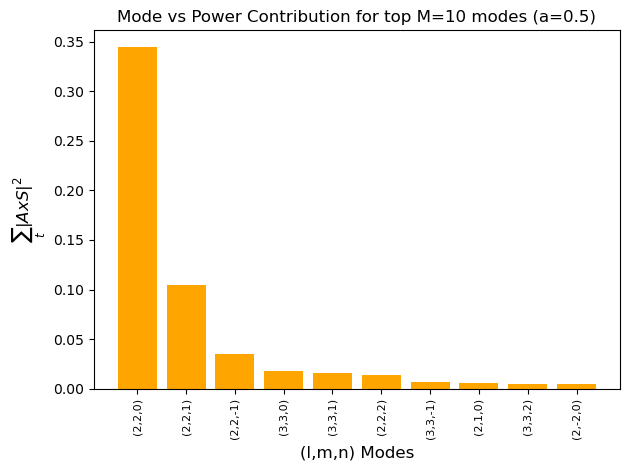

In [16]:
plt.bar(range(len(mp_power)), mp_power, color='orange')
plt.xticks(range(len(mp_modes)), mp_modes, rotation=90, fontsize=8)
plt.xlabel('(l,m,n) Modes', fontsize=12)
plt.ylabel(r'$\sum_{t} |AxS|^2$', fontsize=12)
plt.title('Mode vs Power Contribution for top M={} modes (a={})'.format(M_mode,a), fontsize=12)
plt.yscale('linear')
plt.tight_layout()
plt.show()

In [17]:
# Pick modes based on top M power contributions
top_indices = [mode_labels.index(mode) for mode in mp_modes]
print("Top mode indices:", top_indices)


Top mode indices: [1165, 1166, 1164, 1498, 1499, 1167, 1497, 1054, 1500, 7159]


# Generating mode-forms with FEW func

In [18]:
t_gpu = cp.asarray(t)

In [22]:
%%timeit
waveform_per_mode = []
for idx in top_indices:
    l = amp.l_arr[idx]
    m = amp.m_arr[idx]
    n = amp.n_arr[idx]

    if m >= 0:
        teuk_modes_single = teuk_modes[:, [idx]]
        ylms_single = ylms[[idx]]
        m_arr = amp.m_arr[[idx]]
    else:
        pos_m_mask = (amp.l_arr == l) & (amp.m_arr == -m) & (amp.n_arr == n)
        pos_m_idx = cp.where(pos_m_mask)[0][0]
        teuk_modes_single = (-1)**l * cp.conj(teuk_modes[:, [pos_m_idx]])
        ylms_single = ylms[[idx]]
        m_arr = cp.abs(amp.m_arr[[idx]])  # Use cp.abs instead of np.abs

    waveform = interpolate_mode_sum(
        t_gpu, teuk_modes_single, ylms_single,
        traj.integrator_spline_t, traj.integrator_spline_phase_coeff[:, [0, 2]],
        amp.l_arr[[idx]], m_arr, amp.n_arr[[idx]], 
        dt=dt, T=T
    )
    waveform_per_mode.append(waveform / factor)

cp.cuda.Stream.null.synchronize()

42.9 ms ± 54.5 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%time
waveform_per_mode = []
for idx in top_indices:
    l = amp.l_arr[idx]
    m = amp.m_arr[idx]
    n = amp.n_arr[idx]

    if m >= 0:
        teuk_modes_single = teuk_modes[:, [idx]]
        ylms_single = ylms[[idx]]
        m_arr = amp.m_arr[[idx]]
    else:
        pos_m_mask = (amp.l_arr == l) & (amp.m_arr == -m) & (amp.n_arr == n)
        pos_m_idx = cp.where(pos_m_mask)[0][0]
        teuk_modes_single = (-1)**l * cp.conj(teuk_modes[:, [pos_m_idx]])
        ylms_single = ylms[[idx]]
        m_arr = cp.abs(amp.m_arr[[idx]])  # Use cp.abs instead of np.abs

    waveform = interpolate_mode_sum(
        t_gpu, teuk_modes_single, ylms_single,
        traj.integrator_spline_t, traj.integrator_spline_phase_coeff[:, [0, 2]],
        amp.l_arr[[idx]], m_arr, amp.n_arr[[idx]], 
        dt=dt, T=T
    )
    waveform_per_mode.append(waveform / factor)

cp.cuda.Stream.null.synchronize()

CPU times: user 32.3 ms, sys: 11.9 ms, total: 44.2 ms
Wall time: 44 ms


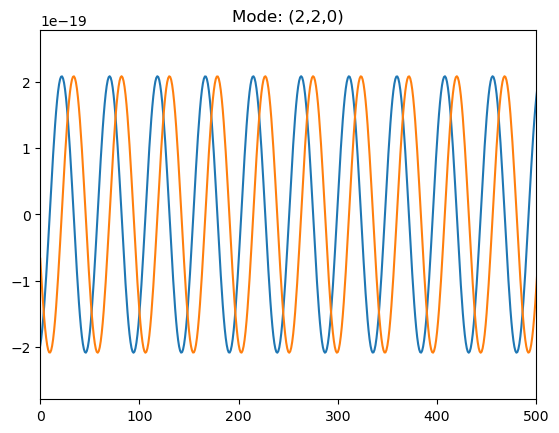

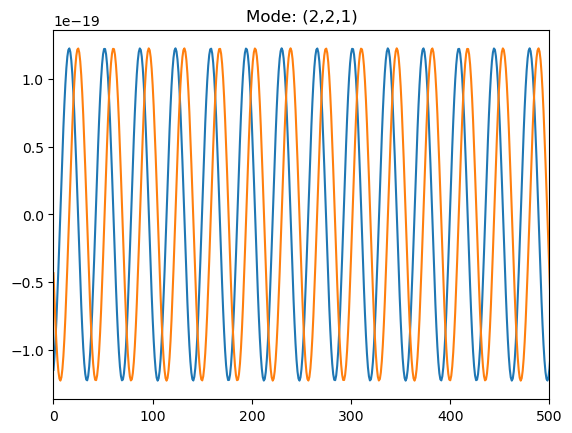

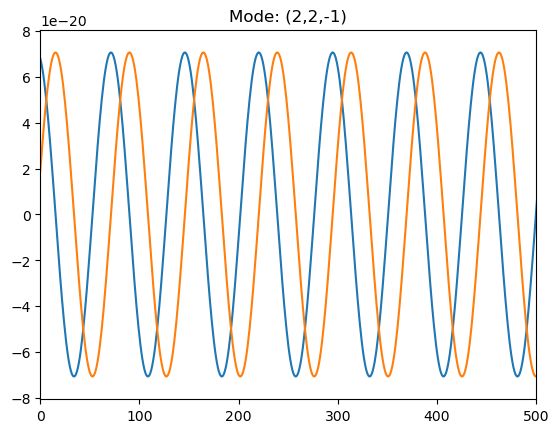

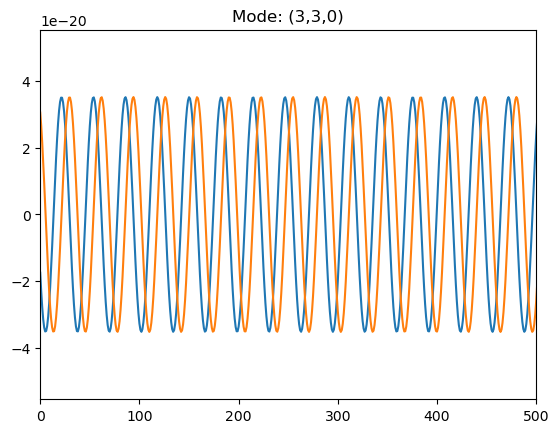

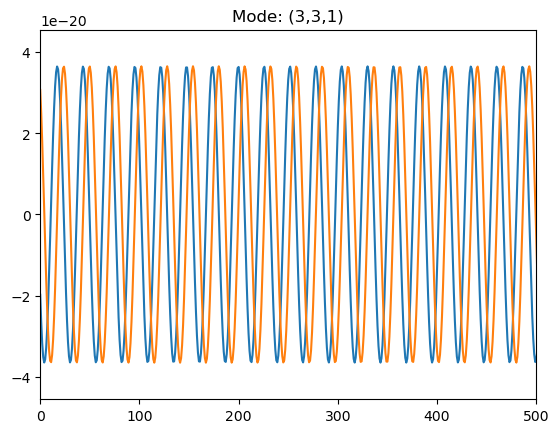

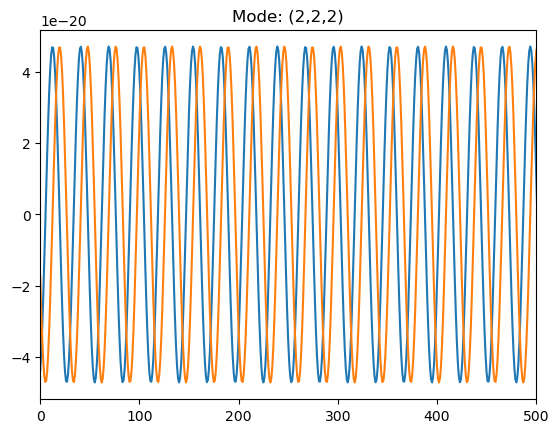

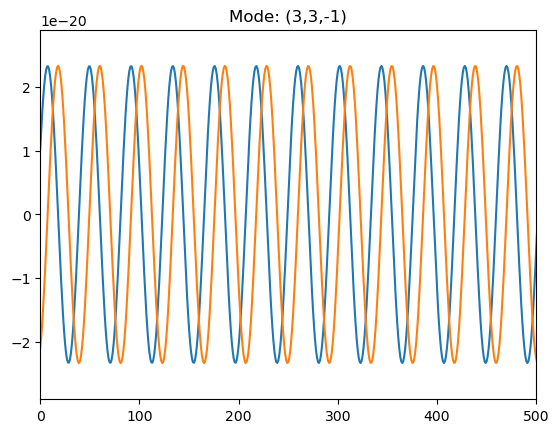

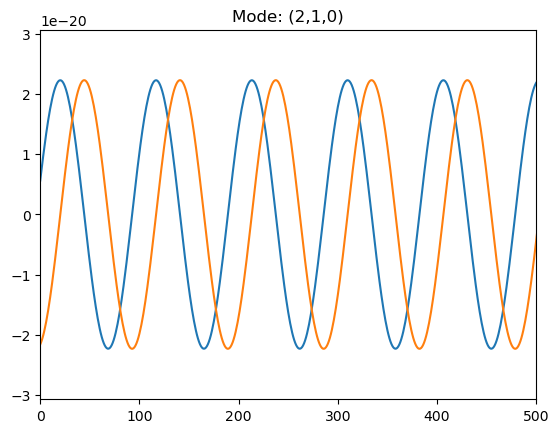

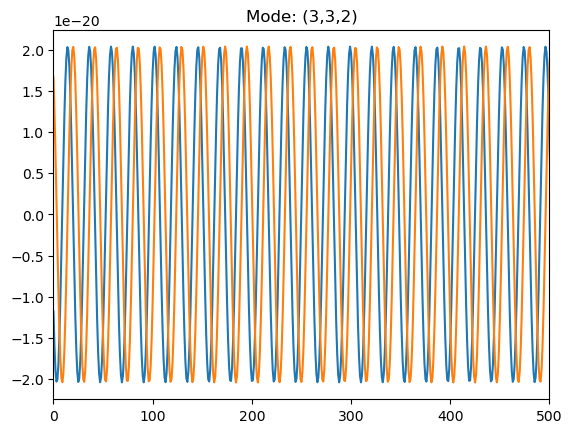

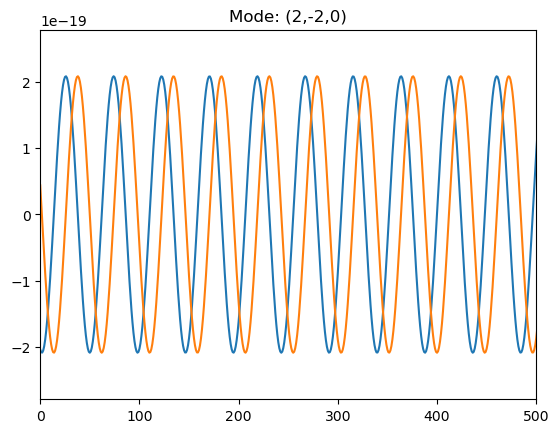

In [24]:
for i, mode_idx in enumerate(top_indices):
    # print(i, mode_idx)
    modeform = waveform_per_mode[i].get()
    plt.plot(modeform.real)
    plt.plot(modeform.imag)
    plt.title(f"Mode: {mode_labels[mode_idx]}")
    plt.xlim(0,500)
    plt.show()

In [29]:
%%timeit
# Pre-compute GPU arrays for all mode data
l_arr_gpu = cp.asarray(amp.l_arr)
m_arr_gpu = cp.asarray(amp.m_arr)
n_arr_gpu = cp.asarray(amp.n_arr)
top_indices_gpu = cp.asarray(top_indices)

# Pre-compute negative m mappings on GPU
neg_m_mappings = {}
for i, idx in enumerate(top_indices):
    m = amp.m_arr[idx]
    if m < 0:
        l, n = amp.l_arr[idx], amp.n_arr[idx]
        pos_m_mask = (l_arr_gpu == l) & (m_arr_gpu == -m) & (n_arr_gpu == n)
        pos_m_idx = cp.where(pos_m_mask)[0][0]
        neg_m_mappings[i] = pos_m_idx

waveform_per_mode = []
for i, idx in enumerate(top_indices):
    l = l_arr_gpu[idx]
    m = m_arr_gpu[idx]
    n = n_arr_gpu[idx]

    if m >= 0:
        teuk_modes_single = teuk_modes[:, [idx]]
        ylms_single = ylms[[idx]]
        m_arr = m_arr_gpu[[idx]]
    else:
        pos_m_idx = neg_m_mappings[i]
        teuk_modes_single = (-1)**l * cp.conj(teuk_modes[:, [pos_m_idx]])
        ylms_single = ylms[[idx]]
        m_arr = cp.abs(m_arr_gpu[[idx]])

    waveform = interpolate_mode_sum(
        t_gpu, teuk_modes_single, ylms_single,
        traj.integrator_spline_t, traj.integrator_spline_phase_coeff[:, [0, 2]],
        l_arr_gpu[[idx]], m_arr, n_arr_gpu[[idx]], 
        dt=dt, T=T
    )
    waveform_per_mode.append(waveform / factor)

cp.cuda.Stream.null.synchronize()

43.4 ms ± 35.7 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
